# Executive Summary

## Problem Statement
To accurately predict the ticket cost of flights leaving Chicago based on Airport, Airline, Type of Ticket, Number of Passengers and Distance travelled.

## Data
Upon exploring the data, I found that a number of flights had discrepencies between 'Miles Flown' and 'Distance Travelled' and so these flights were assumed to be legs of travel packages that included additional travel (and thus were priced higher). The customized 'DiffDis' column reflected this finding. The 'Airport' feature was converted to a dummy variable because the only airports found in this dataset were ORD and MDW. Similar logic was applied to the 'Airline' variables since there are only a finite number of airlines flying out of Chicago. 'Number of Passengers' was standardized by converting it to a natural log of passengers and the 'Type of Ticket' columns were converted to dummy variables. 

## Modeling
Since my goal was to predict ticket price (i.e. a continuous variable) I decided to leverage the Linear Regression and RidgeCV modeling techniques. I found that Linear Regression did as good of a job as RidgeCV and so I conluded that Lienar Regression would be the best option to move forward with given its innate simplicity and ease to use.  

## Conclusions
The metric of success used here was a pre-defined variable known as the R^2 variable. Essentially, a model's R^2 score indicates the amount of variation in the predictor variable that can be explained by the model and what it learned. So when my model generated a score of 0.223 I was able to say that 22.3% of the predicted ticket costs were accounted for by the variables that I included in the training of my model.

Going forward, we can improve on this model if we are given additional information about each flight (for example, destination city and day of the week would strongly help to train our model). 

In [51]:
import pandas as pd 
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
import seaborn as sns

%matplotlib inline

In [52]:
airline = pd.read_csv("airline_10.csv", index_col = 0)
print(airline.head())
print(airline.columns)
print(airline.dtypes)
print(airline[["FarePerMile","Coupons", "Distance", "ItinFare" , "Passengers", "MilesFlown"]].describe())
print(airline.isnull().sum())

#So we know that there are no null values (which is always nice)

               ItinID  FarePerMile  Coupons Origin  RoundTrip  OnLine  \
2936583   20161720654       0.2427        2    ORD        1.0     1.0   
60732    201612861996       0.2103        2    ORD        1.0     1.0   
1735933  201612425797       0.2565        2    ORD        1.0     0.0   
1603577  201614110419       0.2793        2    MDW        1.0     1.0   
2735471  201612424214       0.2054        2    ORD        1.0     1.0   

        RPCarrier  Passengers  ItinFare  BulkFare  Distance  DistanceGroup  \
2936583        AA         1.0     896.0       0.0    3692.0              8   
60732          OO         3.0     426.0       0.0    2026.0              5   
1735933        G7         2.0     534.0       0.0    2082.0              5   
1603577        WN         2.0     405.0       0.0    1450.0              3   
2735471        G7         1.0     355.0       0.0    1728.0              4   

         MilesFlown OriginState  
2936583      3692.0          IL  
60732        2026.0     

(563, 59)
472.84014209591476
392.888211877488
count    12309.000000
mean       392.888212
std        196.072252
min        101.000000
25%        241.000000
50%        356.000000
75%        504.000000
max       1000.000000
Name: ItinFare, dtype: float64
0.0    12309
Name: BulkFare, dtype: int64
IL    12309
Name: OriginState, dtype: int64


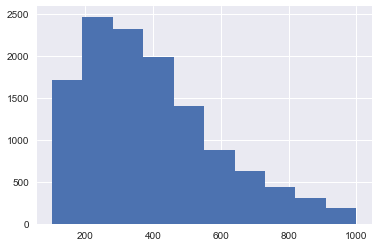

In [53]:
dummies = pd.get_dummies(airline, columns = ["Coupons", "Origin", "RoundTrip", "OnLine", "RPCarrier","DistanceGroup"])

#In the above descibe() results, I noticed some discrepencies between Distance and MilesFlown so I want to explore further

dis_fly_not_equal = dummies.loc[(dummies["Distance"] - dummies["MilesFlown"]) != 0]
print(dis_fly_not_equal.shape)
print(dis_fly_not_equal["ItinFare"].mean())
print(dummies["ItinFare"].mean())

#So we know that there are trips that include some post-flight travel and on average, 
#they cost more than strictly flight travel tickets. So I want them all in the same column and I will treat them
#as a dummy variable (either extra distance is included in the trip, True == 1, or no extra distance, False == 0)

dummies["DisDiff"] = dummies["Distance"] != dummies["MilesFlown"]
y = dummies["ItinFare"]
print(y.describe())
plt.hist(y)

#So we can see that fares are relatively skewed to the right by some highly priced outliers

print(dummies["BulkFare"].value_counts())
print(dummies["OriginState"].value_counts())

#Now we know that all flight's originate in IL and all BulkFares are 0 so both columns are unnecessary
#ASSUMPTION: I predict that ItinID will have no predictable results on Fare beacuse it is random and I am removing ItinFare from dummies because we have it saved in the variable y

dummies.drop(["BulkFare", "OriginState", "ItinID", "ItinFare"], axis = 1, inplace=True)
x_train, x_test, y_train, y_test = model_selection.train_test_split(dummies, y, random_state = 17, train_size = 0.6, test_size = 0.4)

#Now we have our train and test data divvied up so we can start modeling

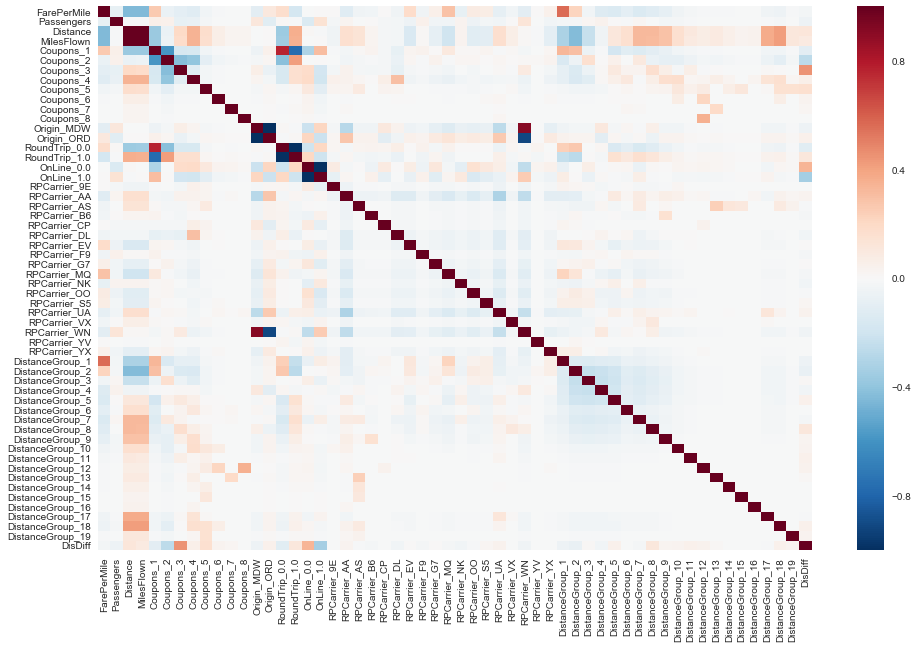

In [54]:
#Before we throw variables into models, I would like to see the correlations amongst variables
#because we want to avoid including two highly correlated variables in the same model
plt.figure(figsize=(16,10))
sns.heatmap(dummies.corr())

R^2: 0.200687464959


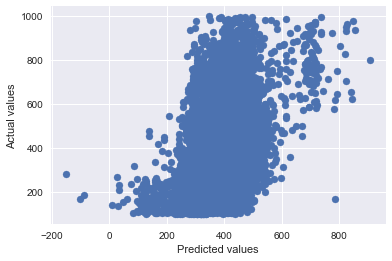

Standardized Coefficients: [ 44.13752399  23.54352671  28.73072741 -19.69368669   7.22461712
  -7.67360529 -11.09929698  -2.5791192   -5.20106621   1.58581808
 -14.8756612   12.56542518 -15.22752716   6.05633078   8.55050463
 -29.02545454   1.05452909  -0.0647256    1.19521398  -4.14624056
   2.79235461  -6.0514534    5.22125718   5.74792433  15.86670528
  13.4403823    9.23443687   3.84701525   1.04893847   8.00231049]


/Users/kenlitton/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [55]:
#IGNORE BELOW COMMENTS => GasMoney was deemed to be an invalid variable for further analysis
# airline["GasMoney"] = airline["Distance"] * airline["FarePerMile"]
# airline.drop(["BulkFare", "OriginState"], axis = 1)
# air_subset = airline.sample(frac = 0.75, replace = False)
# y = air_subset["ItinFare"].values.reshape(-1,1)
# x = air_subset[["Distance", "FarePerMile"]].values
# lr_ridge = linear_model.RidgeCV()
# lr_ridge.fit(x, y)
# print(lr_ridge.score(x, y))
#END OF IGNORE

#In order to carry out modeling at a rapid pace, I want to define functions that will show me the things that I want
#to know about each model

def linreg_scorer(x, y):
    if x.shape[0] == y.shape[0]:
        model = linear_model.LinearRegression()
        model.fit(x, y)
        score = model.score(x, y)
        print("R^2: %s" % score)
        predictions = model.predict(x)
        plt.scatter(predictions, y)
        plt.xlabel("Predicted values")
        plt.ylabel("Actual values")
        plt.show()
        x_stan = preprocessing.scale(x)
        model_stan = linear_model.LinearRegression()
        model_stan.fit(x_stan, y)
        print("Standardized Coefficients: %s" % model_stan.coef_)
    else:
        print("Please input xs and ys of the same shape")
        
def poly_fitter(x, y):
    coef = np.polyfit(x, y, deg=0.5)
    predictions = np.polyval(coef, xs)
    plt.scatter(predictions, y)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.show()
    score = metrics.r2_score(y, predictions)
    print("R^2: %s" % score)
#The weakness of the poly_fitter function is painfully obvious. It is capable of accepting only one variable. IGNORE
    
xs = x_train[["MilesFlown", "Origin_ORD", "RoundTrip_1.0", "Passengers", "OnLine_1.0",
             'RPCarrier_9E','RPCarrier_AA', 'RPCarrier_AS', 'RPCarrier_B6', 'RPCarrier_CP',
              'RPCarrier_DL', 'RPCarrier_EV', 'RPCarrier_F9', 'RPCarrier_G7','RPCarrier_MQ', 
              'RPCarrier_NK', 'RPCarrier_OO', 'RPCarrier_S5','RPCarrier_UA', 'RPCarrier_VX', 
              'RPCarrier_YV','RPCarrier_YX', 'Coupons_2', 'Coupons_3', 'Coupons_4', 'Coupons_5', 
              'Coupons_6','Coupons_7', 'Coupons_8', "DisDiff"]].values

linreg_scorer(xs, y_train)

#A couple of things

#First, I chose not to include every dummy variable from each column because then we would
#have produced an r^2 value of 1 given the program would have been given collectively exhaustive information

#Second, I consulted the heat map to choose which dummies to omit. In the case of the 'Coupons' dummies,
#I chose to ignore Coupons_01 because it had a high correlation with the 'RoundTrip' dummies. The same logic was applied
#to 'RPCarrier_WN' because of its correlation with the 'Origin' dummies

#Last, I chose to omit the 'DistanceGroup' dummies because of their correlation with the 'MilesFlown' and 'FarePerMile'
#variables (which I assume to be more significant to our results)


In [56]:
#ASSUMPTION: I think that this model can be improved. My guess is that MilesFlown and Fare are not directly correlated
#I would like to examine the r^2 value if we included the natural log of MilesFlown

dummies["lnMilesFlown"] = dummies["MilesFlown"].apply(np.log)

#Now I would like to include my new column in our TTS variables and since I am using the same random_state
#I assume that the same rows will be pulled as they were in the above analysis (thus shielding our model
#from the temptations of overfitting with the test data) 
#ASSUMPTION: I assume that we do not need to make another heatmap because the original heatmap will continue to 
#highlight any correlations with our altered lnMilesFlown variable (the ln function simply reduces the magnitude of 
#its victims, not their correlations with other variables)
x_train, x_test, y_train, y_test = model_selection.train_test_split(dummies, y, random_state = 17, train_size = 0.6, test_size = 0.4)
x_train

,FarePerMile,Passengers,Distance,MilesFlown,Coupons_1,Coupons_2,Coupons_3,Coupons_4,Coupons_5,Coupons_6,...,DistanceGroup_12,DistanceGroup_13,DistanceGroup_14,DistanceGroup_15,DistanceGroup_16,DistanceGroup_17,DistanceGroup_18,DistanceGroup_19,DisDiff,lnMilesFlown
1687887,0.1030,2.0,3456.0,3456.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,8.147867
1467077,0.2455,1.0,1214.0,1214.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,7.101676
1395453,0.1602,1.0,3302.0,3302.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,8.102284
2654439,0.1235,2.0,1466.0,1466.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,7.290293
2194908,0.0770,1.0,8414.0,8414.0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,False,9.037652
780345,0.2072,5.0,806.0,806.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,6.692084
219918,0.2059,1.0,2394.0,2394.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,7.780721
3384479,0.2834,1.0,2657.0,2657.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,False,7.884953
344276,0.3843,1.0,1944.0,1944.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,7.572503
426089,0.1757,1.0,1480.0,1480.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,7.299797


R^2: 0.186893459174


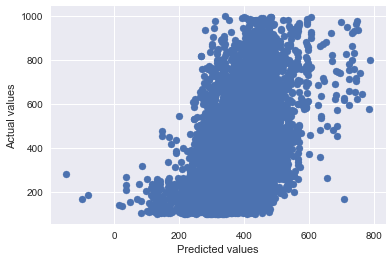

Standardized Coefficients: [ 31.95531583  25.54367392  30.33462627 -20.10775776  11.27016626
  -8.04036686 -11.09457693  -0.03801981  -4.65099687   1.47889626
 -17.51054346  12.33766591 -15.59277504   5.67764168   8.78417116
 -29.66075729   1.09818466  -0.10248959   2.53981121  -3.34830962
   2.82052438  -6.50409666   4.41967185   8.44278272  23.36528904
  18.72687025  10.92089861   4.58707471   1.92256348   7.39208995]


/Users/kenlitton/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [57]:
#Beautiful, now we can use our conveniently defined linreg_scorer function
xs = x_train[["lnMilesFlown", "Origin_ORD", "RoundTrip_1.0", "Passengers", "OnLine_1.0",
             'RPCarrier_9E','RPCarrier_AA', 'RPCarrier_AS', 'RPCarrier_B6', 'RPCarrier_CP',
              'RPCarrier_DL', 'RPCarrier_EV', 'RPCarrier_F9', 'RPCarrier_G7','RPCarrier_MQ', 
              'RPCarrier_NK', 'RPCarrier_OO', 'RPCarrier_S5','RPCarrier_UA', 'RPCarrier_VX', 
              'RPCarrier_YV','RPCarrier_YX', 'Coupons_2', 'Coupons_3', 'Coupons_4', 'Coupons_5', 
              'Coupons_6','Coupons_7', 'Coupons_8', "DisDiff"]].values

linreg_scorer(xs, y_train)


R^2: 0.126470144179


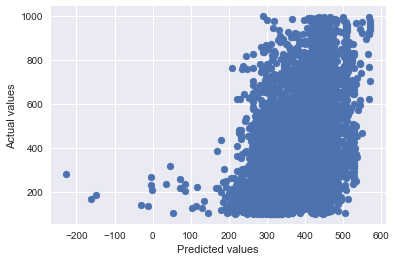

Standardized Coefficients: [ 32.46144094  18.41460465  36.81179511 -23.50216152  -0.72238049
  12.70532424]


/Users/kenlitton/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [58]:
#Well my assumption was incorrect when used with the training data
#Looking back at my work, I am confident that I have included too many variables. Let's truncate

xs = x_train[["lnMilesFlown", "Origin_ORD", "RoundTrip_1.0", "Passengers", "OnLine_1.0", "DisDiff"]].values
linreg_scorer(xs, y_train)

R^2: 0.0606920680648


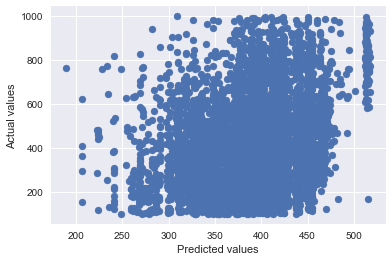

Standardized Coefficients: [ 48.05689915]


In [59]:
#It appears that we have taken a drastic step backwards. I would like to isolate my previous assumption about the 
#relationship between lnMilesFlown and Fare before shuffling around variables again

xs = x_train["lnMilesFlown"].values.reshape(-1,1)
linreg_scorer(xs, y_train)


R^2: 0.0606915639625


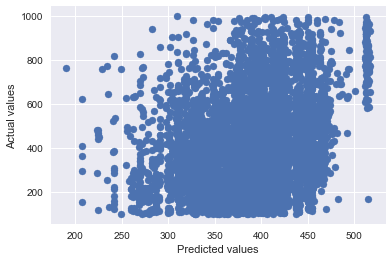

Standardized Coefficients: [ 47.99191349]


In [60]:
#So we are in trouble. I am going to try testing some of these variables against a different type of regression
#to see if results change. I am choosing to test with RidgeCV because cross-validating my data should force the 
#computer to be more rigorous in determining the optimum line of best fit (given RidgeCV's inclusion of penalty
#variables known as alphas)

def ridge_scorer(x, y):
    if x.shape[0] == y.shape[0]:
        model = linear_model.RidgeCV()
        model.fit(x, y)
        score = model.score(x, y)
        print("R^2: %s" % score)
        predictions = model.predict(x)
        plt.scatter(predictions, y)
        plt.xlabel("Predicted values")
        plt.ylabel("Actual values")
        plt.show()
        x_stan = preprocessing.scale(x)
        model_stan = linear_model.RidgeCV()
        model_stan.fit(x_stan, y)
        print("Standardized Coefficients: %s" % model_stan.coef_)
    else:
        print("Please input xs and ys of the same shape")
        
ridge_scorer(xs, y_train)

R^2: 0.126464045147


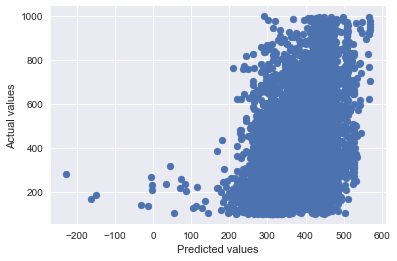

Standardized Coefficients: [ 32.43405818  18.38861922  36.77074322 -23.47083564  -0.74611103
  12.69067873]


/Users/kenlitton/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [61]:
#LinearRegression proved to be a capable model compared to RidgeCV (in this instance) so I would like to test RidgeCV 
#against the previous samples that I chose to model with LinearRegression and compare the results
#This specific test yielded an r^2 of .126

xs = x_train[["lnMilesFlown", "Origin_ORD", "RoundTrip_1.0", "Passengers", "OnLine_1.0", "DisDiff"]].values
ridge_scorer(xs, y_train)

R^2: 0.200685909703


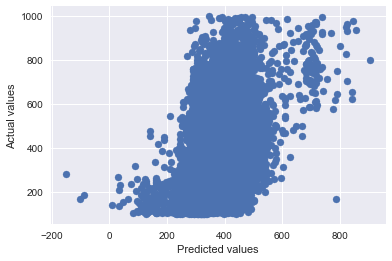

Standardized Coefficients: [ 44.07846648  23.05952994  28.74262962 -19.67043473   7.18967687
  -7.55945975 -10.52369844  -2.45018576  -5.08076957   1.61200542
 -14.62448344  12.78624868 -15.10461879   6.2605185    8.8420922
 -28.79442416   1.33205224   0.11741033   1.7345525   -4.04143668
   2.80886917  -5.83014156   5.17873109   5.72423467  15.80576618
  13.42095852   9.22349089   3.84048036   1.04785179   7.99617261]


/Users/kenlitton/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [62]:
#And this LinearRegression model yielded an r^2 of .20068

xs = x_train[["MilesFlown", "Origin_ORD", "RoundTrip_1.0", "Passengers", "OnLine_1.0",
             'RPCarrier_9E','RPCarrier_AA', 'RPCarrier_AS', 'RPCarrier_B6', 'RPCarrier_CP',
              'RPCarrier_DL', 'RPCarrier_EV', 'RPCarrier_F9', 'RPCarrier_G7','RPCarrier_MQ', 
              'RPCarrier_NK', 'RPCarrier_OO', 'RPCarrier_S5','RPCarrier_UA', 'RPCarrier_VX', 
              'RPCarrier_YV','RPCarrier_YX', 'Coupons_2', 'Coupons_3', 'Coupons_4', 'Coupons_5', 
              'Coupons_6','Coupons_7', 'Coupons_8', "DisDiff"]].values

ridge_scorer(xs, y_train)

R^2: 0.199722773364


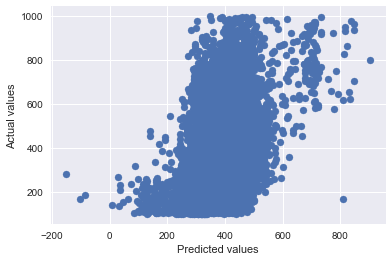

Standardized Coefficients: [ 43.1609952   23.71514258  28.85724202 -19.77634267   6.66258642
  -7.89417178 -11.56657189  -5.2449804  -15.27965843  12.11545652
 -15.28064637   5.68775732   8.10061328 -29.13716517  -6.39070841
   5.45407647   5.98771302  16.3621611   13.29087223   9.32794075
   3.88045864   7.85636927]


/Users/kenlitton/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


1.0      5343
2.0       849
3.0       331
4.0       230
5.0       144
6.0        81
7.0        66
8.0        60
9.0        37
10.0       30
12.0       18
11.0       18
16.0       18
14.0       17
15.0       16
18.0       12
17.0       10
13.0       10
20.0        8
21.0        7
23.0        6
24.0        6
22.0        6
19.0        5
32.0        4
30.0        4
28.0        3
25.0        3
80.0        3
26.0        2
         ... 
41.0        2
29.0        2
31.0        2
27.0        2
35.0        1
43.0        1
93.0        1
42.0        1
54.0        1
36.0        1
46.0        1
62.0        1
66.0        1
116.0       1
70.0        1
40.0        1
57.0        1
129.0       1
150.0       1
61.0        1
37.0        1
47.0        1
69.0        1
33.0        1
52.0        1
60.0        1
48.0        1
88.0        1
38.0        1
44.0        1
Name: Passengers, dtype: int64

In [63]:
#Going forward, I am comfortable using LinearRegression given its simplicty and ability to keep up with
#(and at times exceed) its RidgeCV counterpart

#Now I will leverage the coefficients generated by linreg_scorer to try and isolate the most prescient variables
#In this trial I will only include variables that had coefficients greater than 5

xs = x_train[["MilesFlown", "Origin_ORD", "RoundTrip_1.0", "Passengers", "OnLine_1.0",
             'RPCarrier_9E','RPCarrier_AA','RPCarrier_B6', 'RPCarrier_DL', 'RPCarrier_EV', 
              'RPCarrier_F9', 'RPCarrier_G7','RPCarrier_MQ', 'RPCarrier_NK', 'RPCarrier_YX', 
              'Coupons_2', 'Coupons_3', 'Coupons_4', 'Coupons_5','Coupons_6','Coupons_7', "DisDiff"]].values
linreg_scorer(xs, y_train)

x_train["Passengers"].value_counts()

In [64]:
#This had a negative effect on our r^2 value so I will return to my previous set of variables.
#Underneath the hood of the LinearRegression function, I assume that the function evaluates each variable's influence
#on other variable's effect on y. This is the reason that larger coefficients don't necessarily lead to more accurate
#predictions. By simply removing the weaker influencers, we don't always improve our final results

#Passengers also seems to be a column that we could alter. I am going to test the consequences of including a 
#lnPassengers instead of Passengers

dummies["lnPassengers"] = dummies["Passengers"].apply(np.log)

#Just as we did with lnMilesFlown

x_train, x_test, y_train, y_test = model_selection.train_test_split(dummies, y, random_state = 17, train_size = 0.6, test_size = 0.4)
x_train

,FarePerMile,Passengers,Distance,MilesFlown,Coupons_1,Coupons_2,Coupons_3,Coupons_4,Coupons_5,Coupons_6,...,DistanceGroup_13,DistanceGroup_14,DistanceGroup_15,DistanceGroup_16,DistanceGroup_17,DistanceGroup_18,DistanceGroup_19,DisDiff,lnMilesFlown,lnPassengers
1687887,0.1030,2.0,3456.0,3456.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,8.147867,0.693147
1467077,0.2455,1.0,1214.0,1214.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,7.101676,0.000000
1395453,0.1602,1.0,3302.0,3302.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,8.102284,0.000000
2654439,0.1235,2.0,1466.0,1466.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,7.290293,0.693147
2194908,0.0770,1.0,8414.0,8414.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,False,9.037652,0.000000
780345,0.2072,5.0,806.0,806.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,6.692084,1.609438
219918,0.2059,1.0,2394.0,2394.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,7.780721,0.000000
3384479,0.2834,1.0,2657.0,2657.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,False,7.884953,0.000000
344276,0.3843,1.0,1944.0,1944.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,7.572503,0.000000
426089,0.1757,1.0,1480.0,1480.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,7.299797,0.000000


R^2: 0.219403849575


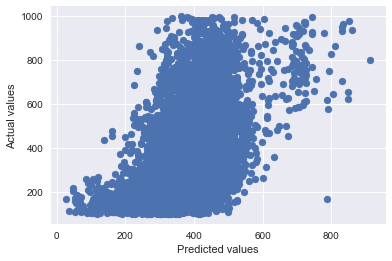

Standardized Coefficients: [  4.51013447e+01   2.14117318e+01   3.40817743e+01  -3.57088015e+01
   1.02855912e+01  -8.12359136e+00  -1.14445192e+01  -2.65928765e+00
  -4.81657156e+00   1.41628694e+00  -1.46986189e+01   9.96173623e+00
  -1.38825257e+01   4.39366150e+00   7.10728856e+00  -2.89127955e+01
  -1.00165783e+00  -1.44480271e+00   3.13914110e-02  -4.00821912e+00
   2.74505628e+00  -7.65234879e+00  -1.19899789e-01  -2.78242077e+00
   7.91405411e+00   1.10845187e+01   8.39574633e+00   3.28234255e+00
   7.44485297e-01   9.18619833e+00]


/Users/kenlitton/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [70]:
#Great. Now we simply plug and chug
xs = x_train[["MilesFlown", "Origin_ORD", "RoundTrip_1.0", "lnPassengers", "OnLine_1.0",
             'RPCarrier_9E','RPCarrier_AA', 'RPCarrier_AS', 'RPCarrier_B6', 'RPCarrier_CP',
              'RPCarrier_DL', 'RPCarrier_EV', 'RPCarrier_F9', 'RPCarrier_G7','RPCarrier_MQ', 
              'RPCarrier_NK', 'RPCarrier_OO', 'RPCarrier_S5','RPCarrier_UA', 'RPCarrier_VX', 
              'RPCarrier_YV','RPCarrier_YX', 'Coupons_2', 'Coupons_3', 'Coupons_4', 'Coupons_5', 
              'Coupons_6','Coupons_7', 'Coupons_8', "DisDiff"]].values
linreg_scorer(xs, y_train)

R^2: 0.224838460278


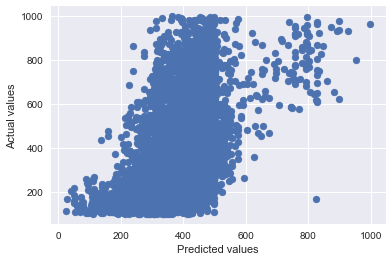

Standardized Coefficients: [  2.06155637e+01   3.48740572e+01  -3.55769816e+01   1.02801275e+01
  -8.32680723e+00  -1.05509385e+01  -3.24453109e+00  -4.27102932e+00
   1.32850723e+00  -1.47955783e+01   9.18779902e+00  -1.37351187e+01
   3.72455781e+00   5.80632375e+00  -2.90562470e+01  -1.83622518e+00
  -1.87180862e+00   3.44130399e-02  -2.94016554e+00   2.85977557e+00
  -8.06145658e+00   1.40912209e+00  -6.39272906e-01   7.92465636e+00
   1.08028673e+01   8.16586748e+00   2.75238498e+00   4.37862147e-01
   8.12293829e+00  -1.07430498e+00   7.17833082e+00   1.49393481e+01
   1.99018405e+01   1.73289999e+01   2.01255410e+01   1.45074744e+01
   1.78083051e+01   1.00515548e+01   4.50693438e+00   6.68875024e+00
   7.59121116e+00   6.37265392e+00   1.76893311e+00   0.00000000e+00
   2.39413559e+01   2.62480960e+01   7.80260832e+00]


/Users/kenlitton/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [76]:
#Okay. We have now improved our r^2 value to .219
#There is one more experiment that I would like to run. I have used the MilesFlown variable in every trial thus far 
#and now I will check to see if the DistanceGroup dummies do a better job
#print(x_train.columns) => so that I could copy and paste the dummies in rather than typing them all out

xs = x_train[["Origin_ORD", "RoundTrip_1.0", "lnPassengers", "OnLine_1.0",
             'RPCarrier_9E','RPCarrier_AA', 'RPCarrier_AS', 'RPCarrier_B6', 'RPCarrier_CP',
              'RPCarrier_DL', 'RPCarrier_EV', 'RPCarrier_F9', 'RPCarrier_G7','RPCarrier_MQ', 
              'RPCarrier_NK', 'RPCarrier_OO', 'RPCarrier_S5','RPCarrier_UA', 'RPCarrier_VX', 
              'RPCarrier_YV','RPCarrier_YX', 'Coupons_2', 'Coupons_3', 'Coupons_4', 'Coupons_5', 
              'Coupons_6','Coupons_7', 'Coupons_8', "DisDiff",'DistanceGroup_2', 'DistanceGroup_3',
               'DistanceGroup_4', 'DistanceGroup_5', 'DistanceGroup_6',
               'DistanceGroup_7', 'DistanceGroup_8', 'DistanceGroup_9',
               'DistanceGroup_10', 'DistanceGroup_11', 'DistanceGroup_12',
               'DistanceGroup_13', 'DistanceGroup_14', 'DistanceGroup_15',
               'DistanceGroup_16', 'DistanceGroup_17', 'DistanceGroup_18',
               'DistanceGroup_19']].values
linreg_scorer(xs, y_train)

/Users/kenlitton/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Standardized Coefficients: [  2.06155637e+01   3.48740572e+01  -3.55769816e+01   1.02801275e+01
  -8.32680723e+00  -1.05509385e+01  -3.24453109e+00  -4.27102932e+00
   1.32850723e+00  -1.47955783e+01   9.18779902e+00  -1.37351187e+01
   3.72455781e+00   5.80632375e+00  -2.90562470e+01  -1.83622518e+00
  -1.87180862e+00   3.44130399e-02  -2.94016554e+00   2.85977557e+00
  -8.06145658e+00   1.40912209e+00  -6.39272906e-01   7.92465636e+00
   1.08028673e+01   8.16586748e+00   2.75238498e+00   4.37862147e-01
   8.12293829e+00  -1.07430498e+00   7.17833082e+00   1.49393481e+01
   1.99018405e+01   1.73289999e+01   2.01255410e+01   1.45074744e+01
   1.78083051e+01   1.00515548e+01   4.50693438e+00   6.68875024e+00
   7.59121116e+00   6.37265392e+00   1.76893311e+00   0.00000000e+00
   2.39413559e+01   2.62480960e+01   7.80260832e+00]
R^2 value with test data: 0.22300659265


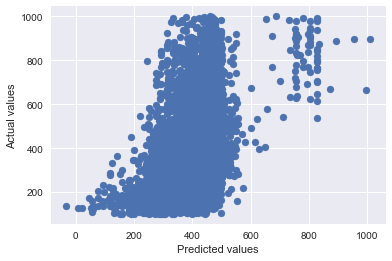

In [88]:
#Okay. It appears that we have our model because .2248 is the best score we've gotten yet
#Now I want to see how it does up against the test data
model = linear_model.LinearRegression()
xs = x_train[["Origin_ORD", "RoundTrip_1.0", "lnPassengers", "OnLine_1.0",
             'RPCarrier_9E','RPCarrier_AA', 'RPCarrier_AS', 'RPCarrier_B6', 'RPCarrier_CP',
              'RPCarrier_DL', 'RPCarrier_EV', 'RPCarrier_F9', 'RPCarrier_G7','RPCarrier_MQ', 
              'RPCarrier_NK', 'RPCarrier_OO', 'RPCarrier_S5','RPCarrier_UA', 'RPCarrier_VX', 
              'RPCarrier_YV','RPCarrier_YX', 'Coupons_2', 'Coupons_3', 'Coupons_4', 'Coupons_5', 
              'Coupons_6','Coupons_7', 'Coupons_8', "DisDiff",'DistanceGroup_2', 'DistanceGroup_3',
               'DistanceGroup_4', 'DistanceGroup_5', 'DistanceGroup_6',
               'DistanceGroup_7', 'DistanceGroup_8', 'DistanceGroup_9',
               'DistanceGroup_10', 'DistanceGroup_11', 'DistanceGroup_12',
               'DistanceGroup_13', 'DistanceGroup_14', 'DistanceGroup_15',
               'DistanceGroup_16', 'DistanceGroup_17', 'DistanceGroup_18',
               'DistanceGroup_19']].values
model.fit(xs, y_train)
x_stan = preprocessing.scale(xs)
model_stan = linear_model.LinearRegression()
model_stan.fit(x_stan, y_train)
print("Standardized Coefficients: %s" % model_stan.coef_)

xs = x_test[["Origin_ORD", "RoundTrip_1.0", "lnPassengers", "OnLine_1.0",
             'RPCarrier_9E','RPCarrier_AA', 'RPCarrier_AS', 'RPCarrier_B6', 'RPCarrier_CP',
              'RPCarrier_DL', 'RPCarrier_EV', 'RPCarrier_F9', 'RPCarrier_G7','RPCarrier_MQ', 
              'RPCarrier_NK', 'RPCarrier_OO', 'RPCarrier_S5','RPCarrier_UA', 'RPCarrier_VX', 
              'RPCarrier_YV','RPCarrier_YX', 'Coupons_2', 'Coupons_3', 'Coupons_4', 'Coupons_5', 
              'Coupons_6','Coupons_7', 'Coupons_8', "DisDiff",'DistanceGroup_2', 'DistanceGroup_3',
               'DistanceGroup_4', 'DistanceGroup_5', 'DistanceGroup_6',
               'DistanceGroup_7', 'DistanceGroup_8', 'DistanceGroup_9',
               'DistanceGroup_10', 'DistanceGroup_11', 'DistanceGroup_12',
               'DistanceGroup_13', 'DistanceGroup_14', 'DistanceGroup_15',
               'DistanceGroup_16', 'DistanceGroup_17', 'DistanceGroup_18',
               'DistanceGroup_19']].values
score = model.score(xs, y_test)
print("R^2 value with test data: %s" % score)
predictions = model.predict(xs)
plt.scatter(predictions, y_test)
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()


R^2 value with test data: 0.185066522625


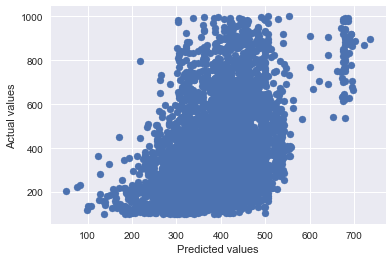

In [81]:
#Okay. So our r^2 yielded consistent results with the test data
#Earier, I created a very simple model that included fewer variables and I am curious to test it against the test data
model = linear_model.LinearRegression()
xs = x_train[["MilesFlown", "Origin_ORD", "RoundTrip_1.0", "lnPassengers", "OnLine_1.0", "DisDiff"]].values
model.fit(xs, y_train)

xs = x_test[["MilesFlown", "Origin_ORD", "RoundTrip_1.0", "lnPassengers", "OnLine_1.0", "DisDiff"]].values
score = model.score(xs, y_test)
print("R^2 value with test data: %s" % score)
predictions = model.predict(xs)
plt.scatter(predictions, y_test)
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

So upon further analysis of my models, I am choosing to go with this one
```
model = linear_model.LinearRegression()
xs = x_train[["Origin_ORD", "RoundTrip_1.0", "lnPassengers", "OnLine_1.0",
             'RPCarrier_9E','RPCarrier_AA', 'RPCarrier_AS', 'RPCarrier_B6', 'RPCarrier_CP',
              'RPCarrier_DL', 'RPCarrier_EV', 'RPCarrier_F9', 'RPCarrier_G7','RPCarrier_MQ', 
              'RPCarrier_NK', 'RPCarrier_OO', 'RPCarrier_S5','RPCarrier_UA', 'RPCarrier_VX', 
              'RPCarrier_YV','RPCarrier_YX', 'Coupons_2', 'Coupons_3', 'Coupons_4', 'Coupons_5', 
              'Coupons_6','Coupons_7', 'Coupons_8', "DisDiff",'DistanceGroup_2', 'DistanceGroup_3',
               'DistanceGroup_4', 'DistanceGroup_5', 'DistanceGroup_6',
               'DistanceGroup_7', 'DistanceGroup_8', 'DistanceGroup_9',
               'DistanceGroup_10', 'DistanceGroup_11', 'DistanceGroup_12',
               'DistanceGroup_13', 'DistanceGroup_14', 'DistanceGroup_15',
               'DistanceGroup_16', 'DistanceGroup_17', 'DistanceGroup_18',
               'DistanceGroup_19']].values
model.fit(xs, y_train)
```
This model appears to be confusing at first glance but after boiling down the dummies it really only takes into account 8 unique variables
1)Airport
2)RountTrip
3)Passengers
4)Returning flight w/ same airline
5)Airline
6)Coupons
7)Additional travel after flight
8)Distance travelled

The coefficients are straightforward as well. A variable's coefficient lets us know how much y will be affected by a one unit increase in that variable (and this is why we normalize xs before solving for coeffients). For example, we can see that in the above model, lnPassengers has the single greatest influence on Fare because with an increase of 1 in lnPassengers, we see a corresponding decrease of 35.57 in ItinFare. Buying tickets for more passengers on a given flight(maybe more friends) is the strongest way to cut down on your total ticket costs
